In [1]:
import glob
import pickle
import seaborn as sns
import pandas as pd
from metrics import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.stats import weightstats as stests
import scipy
from scipy import spatial
from data import one_hot
import numpy as np

In [2]:
# load RSA values of final iteration
def RSA(paths, metric="loss"):
    
    results = {}
    for path in paths:
        results[path] = {}
        for m in glob.glob(path + "/*/*.pkl"):

            seed = m.split('/')[2]
            if seed not in results[path]:
                results[path][seed] = {}

            it = m.split('_')[-1].split('.')[0]

            if it == 'metrics':
                continue

            iteration = int(it)
            
            # get the 

            results[path][seed][iteration] = pickle.load(open(m, 'rb'))
                
    return results

# load generalization scores
def load_metrics(path):
    """
        This function loads metrics at the end of an experiment
    """

    # load the data
    seed_folders = glob.glob(f"{path}/*")

    # save results
    generalize_result = {}
    generalize_related_result = {}
    train_result = {}

    # run through all seed
    for s in seed_folders:

        # get seed index
        seed = s.split("/")[-1]
        
        # make sure to ignore the rsa analysis for now
        if seed == 'rsa_analysis.pkl':
            continue

        # get all metric files
        metric_files = glob.glob(s + "/*.pkl")

        for file in metric_files:

            # load files
            m1 = pickle.load(open(file, "rb"))

            # check if file is generalize or train metric
            if file.find('generalize') == -1:
                if file.find('10000') != -1:
                    train_result[seed] = m1
            else:
                if file.find('generalize_related') == -1:
                    generalize_result[seed] = m1
                else:
                    generalize_related_result[seed] = m1
                                

    return train_result, generalize_result, generalize_related_result



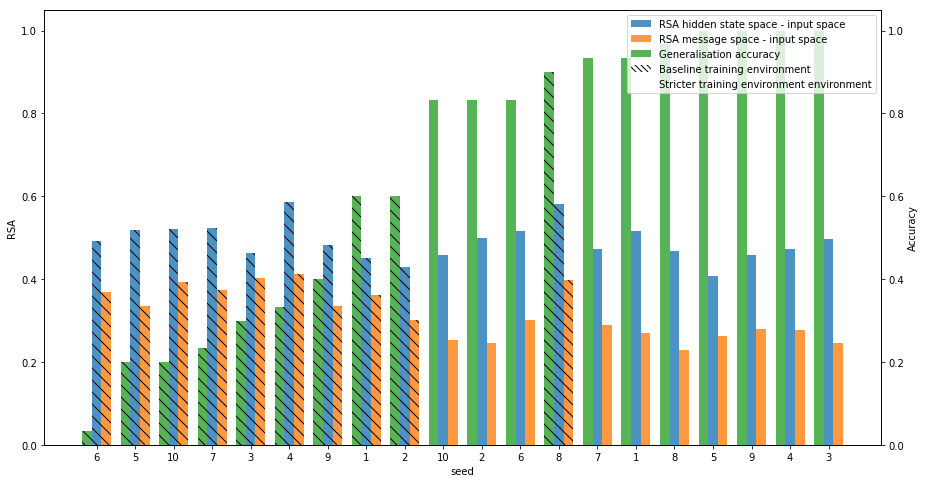

In [4]:
paths = ["runs/lstm_max_len_5_vocab_5_same_data_attr_4_related_split_2",
        "runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2"]

rsa = RSA(paths)

# figure stats
fig, ax = plt.subplots(figsize=(15,8))
index = np.arange(20)

# initialize empty lists
all_hidden = []
all_mess = []
all_gen = []
all_type = []
seeds = []


for i, path in enumerate(paths):

    # bar stats
    bar_width = 0.25
    opacity = 0.7
    
    # load generalization
    if i:
        _, _, generalize = load_metrics(path)
    else:
        _, generalize,_ = load_metrics(path)
    
    # extract data
    for s in range(1,11):
        seed = str(s)
        hidden_tar = rsa[path][seed][10000]['RSA:h_receiver/targets']
        tar_mess = rsa[path][seed][10000]['RSA:targets/messages']
        
        gen_acc = generalize[seed]['acc']
        
        all_hidden.append(hidden_tar)
        all_mess.append(tar_mess)
        all_gen.append(gen_acc)
        all_type.append(i)
        seeds.append(s)
        
# sort list by generalization        
all_gen, all_hidden, all_mess, all_type, seeds = zip(*sorted(zip(all_gen, all_hidden, all_mess, all_type, seeds)))

# need to make bars per every experiment type

# plot the bar
hiddenBar = ax.bar(index, all_hidden, bar_width,
        alpha=0.8,
        label='RSA hidden - targets')

messageBar = ax.bar(index+0.25, all_mess, bar_width,
        alpha=0.8,
        label='RSA targets - messages')

genBar = ax.bar(index-0.25, all_gen, bar_width,
        alpha=0.8,
        label='Generalization accuracy')
    
# give pattern to certain experiment setup
patterns = ('\\\\')
for i, bar in enumerate(hiddenBar):
    if all_type[i]:
        hiddenBar[i].set_hatch(patterns)
        messageBar[i].set_hatch(patterns)
        genBar[i].set_hatch(patterns)
    
#plt.title('Comparison between strict and easy environment')

plt.xlabel('seed')
plt.xticks(index, tuple([i for i in seeds]))

ax.set_ylabel('RSA')

# create secondary y axis for accuracy
ax2 = ax.twinx()
ax2.set_ylim([0, 1.05])
ax2.set_ylabel('Accuracy')

handles = []
# manually define a legend
handles.append(mpatches.Patch(facecolor=hiddenBar.patches[0].get_facecolor(), label = 'RSA hidden state space - input space'))
handles.append(mpatches.Patch(facecolor=messageBar.patches[0].get_facecolor(), label = 'RSA message space - input space'))
handles.append(mpatches.Patch(facecolor=genBar.patches[0].get_facecolor(), label = 'Generalisation accuracy'))
handles.append(mpatches.Patch(facecolor='white', hatch=r'\\\\', label='Baseline training environment'))
handles.append(mpatches.Patch(facecolor='white', label='Stricter training environment environment'))
plt.legend(handles=handles)


plt.show()
        



# RSA barplot

Tests for normality:
(0.9836558699607849, 0.9817073941230774)
(0.9404076933860779, 0.5575585961341858) 

p-value:  3.984855028467774e-07 

p-value:  1.8346269997028815e-07 



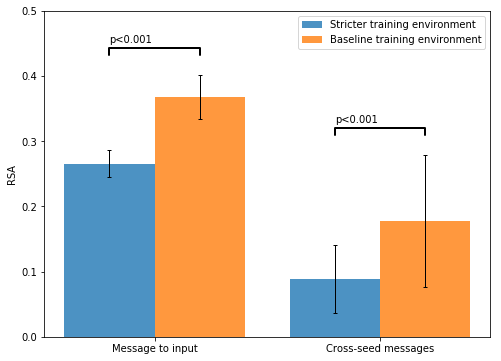

In [13]:
##########################
# Message to input space #
##########################

# extract all values

paths = ["runs/lstm_max_len_5_vocab_5_same_data_attr_4_related_split_2",
        "runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2"]

rsa = RSA(paths)

# initialize empty lists
mess_input_avg = []
mess_input_std = []

full_mess_input = []

for i, path in enumerate(paths):
      
    all_rsa = []
    all_random_rsa = []
    
    # extract data
    for s in range(1,11):
        seed = str(s)
        
        # extract rsa values
        tar_mess = rsa[path][seed][10000]['RSA:targets/messages']                        
        all_rsa.append(tar_mess)
        
        if i:
            all_random_rsa.append(rsa[path][seed][0]['RSA:targets/messages'])
            
        
    # get average and std dev
    mess_input_avg.append(np.mean(all_rsa))
    mess_input_std.append(np.std(all_rsa))
    full_mess_input.append(all_rsa)
    
    if i: 
        mess_input_avg.append(np.mean(all_random_rsa))
        mess_input_std.append(np.std(all_random_rsa))
        full_mess_input.append(all_random_rsa)
    
    

#######################
# Cross-seed messages #
#######################

rsa = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2/rsa_analysis.pkl', 'rb'))

rsa_related = pickle.load(open(
    f'runs/lstm_max_len_5_vocab_5_same_data_attr_4_related_split_2/rsa_analysis.pkl', 'rb'))

# initialize lists
all_rsa = []
all_rsa_related = []
all_random_rsa = []

# extract data
for value in rsa_related['messages'].values():
    if value:
        all_rsa_related.append(value[10000])        
        
for value in rsa['messages'].values():
    if value:
        all_rsa.append(value[10000])
        all_random_rsa.append(value[0])
        
# extract the cross seed values
cross_avg = [np.mean(all_rsa_related), np.mean(all_rsa), np.mean(all_random_rsa)]
cross_std = [np.std(all_rsa_related), np.std(all_rsa), np.std(all_random_rsa)]

full_cross = [all_rsa_related, all_rsa, all_random_rsa]
        
############
# Bar plot #
############

# figure stats
fig, ax = plt.subplots(figsize=(8,6))
index = np.arange(2)
labels = ['Message to input', 'Cross-seed messages']

# bar stats
bar_width = 0.4

# convert data to proper structure
bar1_data = [mess_input_avg[0], cross_avg[0]]
bar1_error = [mess_input_std[0], cross_std[0]]

bar2_data = [mess_input_avg[1], cross_avg[1]]
bar2_error = [mess_input_std[1], cross_std[1]]

# bar for the message-input RSA
relatedRsaBar = ax.bar(index, bar1_data, bar_width, yerr=bar1_error, alpha=0.8, label='Stricter training environment',
                      error_kw=dict(lw=1, capsize=2, capthick=1))

# bar for the cross seed RSA
rsaBar = ax.bar(index+0.4, bar2_data, bar_width, yerr=bar2_error,
                alpha=0.8,
                label='Baseline training environment',
                error_kw=dict(lw=1, capsize=2, capthick=1))



##############
# Statistics #
##############

# function to draw statistics in the figure
def label_diff(index, data1, data2, text, label_distance=0.045):

    x = index+ 0.2
    y = max(data1, data2)

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(index,y+label_distance), zorder=10)
    ax.annotate('', xy=(index,y), xytext=(index+0.4,y), arrowprops=props)

# t test due to sample size of 10
x, p = scipy.stats.ttest_ind(full_mess_input[0], full_mess_input[1])
print("Tests for normality:")
print(scipy.stats.shapiro(full_mess_input[0]))
print(scipy.stats.shapiro(full_mess_input[1]), '\n')

print("p-value: ", p, '\n')

# z-test due to sample size of 45
x, p = stests.ztest(full_cross[0], x2=full_cross[1], alternative='two-sided')

print("p-value: ", p, '\n')



# # Call the function
label_diff(index[0],(bar1_data[0]+bar1_error[0]), (bar2_data[0]+bar2_error[0]),'p<0.001', label_distance=0.05)
label_diff(index[1],(bar1_data[1]+bar1_error[1]), (bar2_data[1]+bar2_error[1]),'p<0.001', label_distance=0.05)

# set labels
ax.set_xticks(index + 0.2)
ax.set_xticklabels(labels)

ax.set_ylabel('RSA')
ax.set_ylim([0,0.50])
ax.legend()

plt.show()



Tests for normality:
(0.9404076933860779, 0.5575585961341858)
(0.8070634603500366, 0.01766473427414894) 

p-value:  5.753636902111001e-08 

p-value:  1.2639841075243975e-17


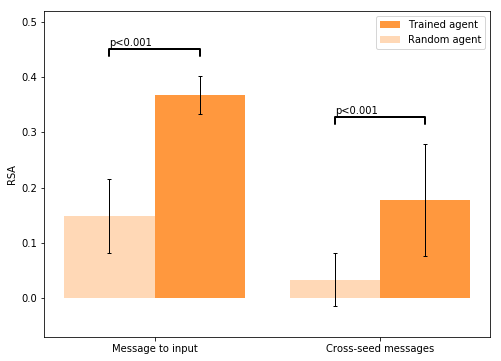

In [9]:
# figure stats
fig, ax = plt.subplots(figsize=(8,6))
index = np.arange(2)
labels = ['Message to input', 'Cross-seed messages']

# bar stats
bar_width = 0.4

# convert data to proper structure
bar1_data = [mess_input_avg[1], cross_avg[1]]
bar1_error = [mess_input_std[1], cross_std[1]]

bar2_data = [mess_input_avg[2], cross_avg[2]]
bar2_error = [mess_input_std[2], cross_std[2]]

# bar for the message-input RSA
randomRsaBar = ax.bar(index+0.4, bar1_data, bar_width, yerr=bar1_error,
                      color=(1.0, 0.4980392156862745, 0.054901960784313725, 0.8),
                      label='Trained agent',
                      error_kw=dict(lw=1, capsize=2, capthick=1))

# bar for the cross seed RSA
rsaBar = ax.bar(index, bar2_data, bar_width, yerr=bar2_error,
                color=(1.0, 0.4980392156862745, 0.054901960784313725, 0.3),                
                label='Random agent',
                error_kw=dict(lw=1, capsize=2, capthick=1))

##############
# Statistics #
##############

# t-test due to sample size of 10
x, p = scipy.stats.ttest_ind(full_mess_input[1], full_mess_input[2])
print("Tests for normality:")
print(scipy.stats.shapiro(full_mess_input[1]))
print(scipy.stats.shapiro(full_mess_input[2]), '\n')

print("p-value: ", p, '\n')

# z-test due to greater sample size of 45
x, p = stests.ztest(full_cross[1], x2=full_cross[2], alternative='two-sided')
print("p-value: ",p)

label_diff(index[0],(bar1_data[0]+bar1_error[0]), (bar2_data[0]+bar2_error[0]),'p<0.001', label_distance=0.055)
label_diff(index[1],(bar1_data[1]+bar1_error[1]), (bar2_data[1]+bar2_error[1]),'p<0.001', label_distance=0.055)

# set labels
ax.set_xticks(index + 0.2)
ax.set_xticklabels(labels)

ax.set_ylabel('RSA')
ax.set_ylim([-0.07,0.52])
ax.legend()

plt.show()


